# [Insert Creative Title HERE]

## Introduction and Motivation

## Required Libraries

Intro to Pandas:
https://pandas.pydata.org/pandas-docs/version/0.15/tutorials.html

Learning the Spotify API through spotipy:
https://spotipy.readthedocs.io/en/latest/#


In [1]:
import sys
import pandas as pd
import numpy as np
import spotipy
import spotipy.util as util
import matplotlib.pyplot as plt
from sklearn import cluster, decomposition
import plotly.graph_objects as go
import seaborn

## Data Collection and Tidying
//TODO Talk about general authentication flow.<br>
//TODO Link example resource. <br>
//TODO Explain how to get the spotify username<br>
//TODO talk about how we chose what columns to keep. Talk about how data is relatively simple and no need to reorganize

In [2]:
# Generate authorization token for reading user library
username = '12124976904'

scope = 'user-library-read'
client_id = '076ff5215a374d2481d0117877d79b74'
client_secret = '0ff2fd29106e4b7ebd7da4152d4a20c3'
redirect_uri = 'https://www.google.com/'

token = util.prompt_for_user_token(username, scope, client_id, client_secret, redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)

else:
    print("Can't get token for", username)
    sys.exit()



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=076ff5215a374d2481d0117877d79b74&response_type=code&redirect_uri=https%3A%2F%2Fwww.google.com%2F&scope=user-library-read in your browser


Enter the URL you were redirected to: https://www.google.com/?code=AQAcky2h001QNWNNYwn7GESnEwfI3N2jFTiVZvz6vZTjzdwIDy1KTcV1r6icT-gGrJ5fsH_e2PLKhl7pxKQ3EqQtP3UVF4Y0BsJF7tpNo9iRdiAqBF8qwxr0n4B8y--KjVKhacmwJOTFHA6NZe4YMby88YWsc5z5XWkCaBk9DMgQ4draCGgFQEiS7YyTjRqjZQlHHKhsPzE0x-guBEPtkQ




//TODO explain the code flow <br>
//TODO talk about how we chose what columns to keep. <br>
//TODO Talk about how data is relatively simple and no need to reorganize <br>

In [15]:
def get_saved_tracks():
    results = sp.current_user_saved_tracks()
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

print('Loading Saved Tracks Now. Please be patient!')

if True:
    tracks = get_saved_tracks()
    features = []
    track_info = []
    for track in tracks:
        features.extend(sp.audio_features(track['track']['uri']))
        track_info.append([track['track']['name'], track['track']['artists'][0]['name']])

    features = pd.DataFrame.from_records(features)
    track_info = pd.DataFrame.from_records(track_info)
    track_info = track_info.rename(columns={0: "title", 1: "artist"})
    #features = pd.concat([track_info,features],axis=1)
    features = features[['acousticness', 'danceability', 'energy', 'instrumentalness', 'tempo', 'valence']]
    features['tempo'] = (features['tempo']-features['tempo'].min())/(features['tempo'].max()-features['tempo'].min())

else:
    features = pd.read_csv('sample_data') #TODO download the dataframe as a csv and add to path
    
features #TODO Add Name and Artist

Loading Saved Tracks Now. Please be patient!
retrying ...4secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...4secs
retrying ...4secs
retrying ...4secs
retrying ...1secs


,acousticness,danceability,energy,instrumentalness,tempo,valence
0,0.356000,0.586,0.918,0.001530,0.379245,0.310
1,0.880000,0.324,0.428,0.000013,0.784055,0.243
2,0.017500,0.810,0.731,0.000141,0.589816,0.622
3,0.011600,0.562,0.850,0.000000,0.470217,0.410
4,0.162000,0.725,0.680,0.000002,0.431567,0.760
...,...,...,...,...,...,...
423,0.000056,0.579,0.865,0.000221,0.333120,0.358
424,0.469000,0.576,0.451,0.038900,0.237295,0.803
425,0.360000,0.671,0.740,0.000000,0.214200,0.908
426,0.150000,0.424,0.875,0.000000,0.748454,0.440


## Exploratory Data Analysis & Visualizations

In [ ]:
#Explain the columns and how values are determined.
# Summary Statistics
# Histograms
# Correlation Graphs

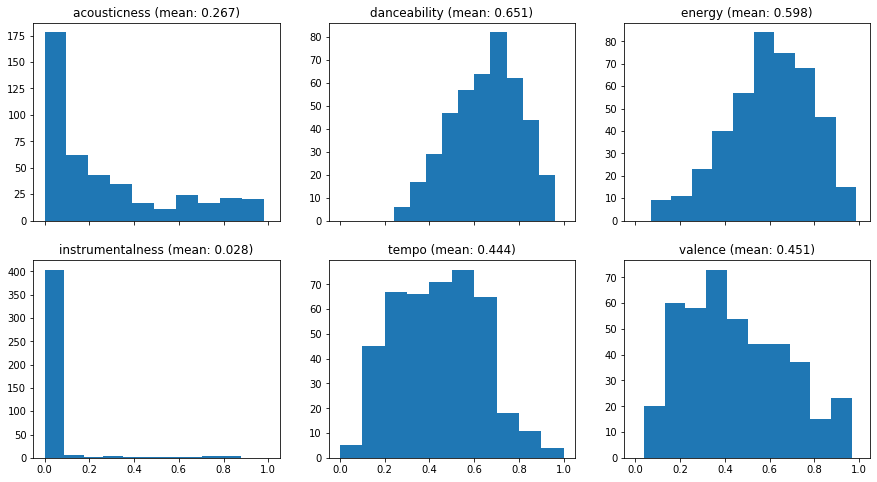

In [16]:
fig, ax = plt.subplots(2, 3, sharex=True, figsize=(15,8))
ax = ax.flatten()
idx = 0

for col in features.columns:
    ax[idx].hist(features[col])
    ax[idx].set_title(col + " (mean: " + str(np.round(features[col].mean(), 3)) + ")")
    idx += 1

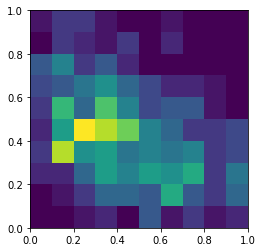

In [17]:
h, xedges, yedges = np.histogram2d(features['energy'], features['valence'])
plt.imshow(h, extent=[0, 1, 0, 1])

## Machine Learning

In [ ]:
# Found cool article on PCA & One Class SVM here:
# https://medium.com/cuepoint/visualizing-hundreds-of-my-favorite-songs-on-spotify-fe50c94b8af3
# Implementation is found here:
# http://www.esparsons.com/blogmain/2018/11/27/an-eclectic-spotify-library-visualized-with-chartify

#TODO PCA Analysis
#TODO One Class SVM
#TODO Clustering

#TODO Error analysis...
#TODO Check if new playlists can fit into the SVM

### Clustering & Principal Component Analysis

In [18]:
clusters = cluster.AffinityPropagation(preference=0).fit(features.values)
pref = 0

while (len(clusters.cluster_centers_) > 10):
    pref -= 1
    clusters = cluster.AffinityPropagation(preference=pref).fit(features.values)
    
features['Cluster'] = clusters.labels_
num_clusters = len(clusters.cluster_centers_)
print("Number of clusters found: " + str(num_clusters))

Number of clusters found: 9


In [20]:
pca = decomposition.PCA(n_components=2)
features_2d = pd.DataFrame(pca.fit_transform(features), columns=['Component 1', 'Component 2'])
features_2d['Cluster'] = clusters.labels_
features_2d.head(10)

,Component 1,Component 2,Cluster
0,3.622235,-0.041271,1
1,-2.376067,0.693663,7
2,-3.386430,-0.329214,8
3,3.620170,-0.324736,1
4,-3.383336,-0.196159,8
5,4.616681,-0.281730,0
6,-1.385060,-0.164528,6
7,1.624002,0.737372,3
8,-3.384090,-0.053083,8
9,-0.381799,-0.192835,5


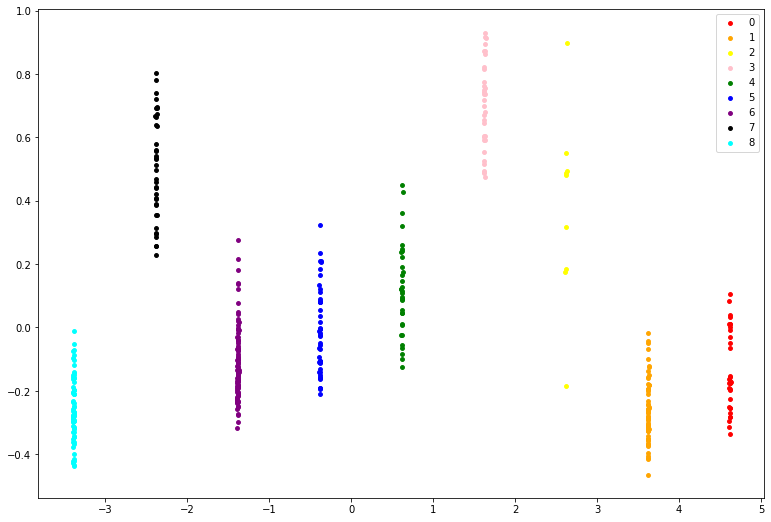

In [21]:
colors = ['red', 'orange', 'yellow', 'pink', 'green', 'blue', 'purple', 'black', 'cyan', 'grey']
fig, ax = plt.subplots(figsize=(13,9))
features_2d = features_2d.sort_values('Cluster')

for cluster_label in features_2d['Cluster'].unique():
    group = features_2d.loc[features_2d['Cluster'] == cluster_label]
    ax.scatter(group['Component 1'], group['Component 2'], c = colors[cluster_label], label=cluster_label, s=15)
    
ax.legend()

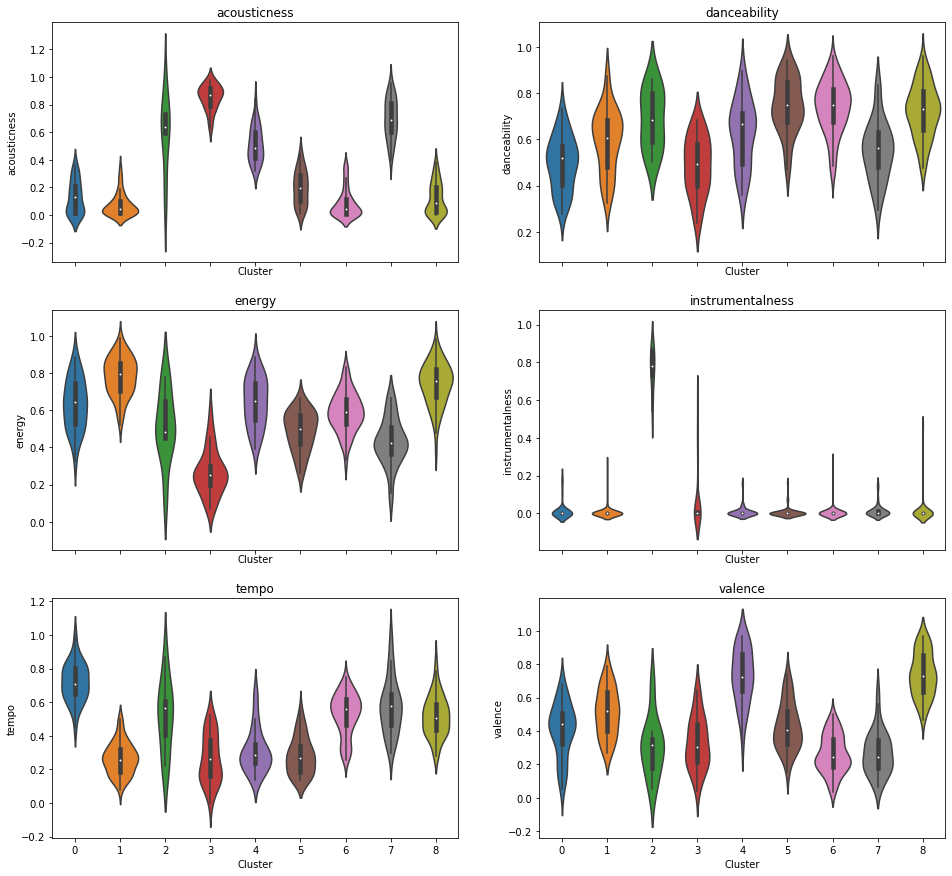

In [22]:
fig, ax = plt.subplots(3, 2, sharex=True, figsize=(16, 15))
ax = ax.flatten()
idx = 0

for col in features.loc[:,:'valence'].columns:
    seaborn.violinplot(features['Cluster'], features[col], ax=ax[idx])
    ax[idx].set_title(col)
    idx += 1
    
#some of these look weird, can mess with it more later

## Takeaways 